In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2024-05-28 22:13:58.367521: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
revised = pd.read_csv('../data/response.csv', index_col=0)
revised.fillna(0, inplace=True)
revised

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/2010 0:00,0.33,0.34,0.0,0.0,2.17,0.49,0.000,0.0,0.00,2.84,0.58,0.0,0.000,0.0,0.00,2.78,0.505,0.0,0.0
1/1/2010 1:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.000,0.0,0.00,2.84,-0.07,0.0,0.000,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/2010 2:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.000,0.0,0.00,2.84,-0.62,0.0,0.000,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/2010 3:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.000,0.0,0.00,2.83,-0.82,0.0,0.000,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/2010 4:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.000,0.0,0.00,2.84,-0.53,0.0,0.000,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/2020 19:00,1.62,1.07,0.0,0.0,1.88,1.65,28.558,0.0,2.56,2.39,1.70,0.0,38.701,0.0,2.57,2.57,1.670,0.0,0.0
12/30/2020 20:00,1.93,1.44,0.0,0.0,1.88,1.95,23.088,0.0,2.57,2.45,2.00,0.0,30.055,0.0,2.57,2.55,2.000,0.0,0.0
12/30/2020 21:00,2.19,1.58,0.0,0.0,1.89,2.21,17.084,0.0,2.57,2.49,2.25,0.0,21.915,0.0,2.57,2.56,2.250,0.0,0.0


In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

In [6]:
stages = revised[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96408, 4)
stages_supervised.shape: (96217, 768)


In [7]:
non_stages = revised[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S25B', 'PUMP_S26', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96408, 7)
non_stages_supervised.shape: (96241, 1176)


In [8]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96217, 1176)


In [9]:
n_features = stages.shape[1] + non_stages.shape[1]
n_features

11

In [10]:
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [11]:
print("all_data.shape:", all_data.shape)

all_data.shape: (96217, 1944)


In [12]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
test = all_data[76968:, :]

n_obs = n_hours * n_features
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]

In [13]:
test_X.shape

(19249, 1848)

In [14]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

In [15]:
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("test_X.shape, test_y.shape: \n", test_X.shape, test_y.shape)

test_X.shape, test_y.shape: 
 (19249, 168, 11) (19249, 96)


In [16]:
model_mlp = keras.models.load_model('../saved_model/mlp.h5')
model_rnn = keras.models.load_model('../saved_model/rnn.h5')
model_lstm = keras.models.load_model('../saved_model/lstm.h5')
model_cmlp = keras.models.load_model('../saved_model/cnn.h5')
model_crnn = keras.models.load_model('../saved_model/rcnn.h5')

2024-05-28 22:14:13.997800: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-28 22:14:14.000302: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-28 22:14:14.041954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2024-05-28 22:14:14.042025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-28 22:14:14.045136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-28 22:14:14.045181: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [17]:
yhat_mlp = model_mlp.predict(test_X)
yhat_rnn = model_rnn.predict(test_X)
yhat_lstm = model_lstm.predict(test_X)
yhat_cmlp = model_cmlp.predict(test_X)
yhat_crnn = model_crnn.predict(test_X)

2024-05-28 22:14:16.478328: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-28 22:14:16.479154: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1700105000 Hz
2024-05-28 22:14:16.595382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-28 22:14:45.308895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-05-28 22:14:47.059735: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [18]:
inv_yhat_mlp = scaler.inverse_transform(yhat_mlp)
inv_yhat_rnn = scaler.inverse_transform(yhat_rnn)
inv_yhat_lstm = scaler.inverse_transform(yhat_lstm)
inv_yhat_cmlp = scaler.inverse_transform(yhat_cmlp)
inv_yhat_crnn = scaler.inverse_transform(yhat_crnn)

In [19]:
inv_yhat_mlp = inv_yhat_mlp[-1:, :]
inv_yhat_rnn = inv_yhat_rnn[-1:, :]
inv_yhat_lstm = inv_yhat_lstm[-1:, :]
inv_yhat_cmlp = inv_yhat_cmlp[-1:, :]
inv_yhat_crnn = inv_yhat_crnn[-1:, :]

In [20]:
inv_yhat_mlp_reshape = np.reshape(inv_yhat_mlp, (-1,4))
inv_yhat_rnn_reshape = np.reshape(inv_yhat_rnn, (-1,4))
inv_yhat_lstm_reshape = np.reshape(inv_yhat_lstm, (-1,4))
inv_yhat_cmlp_reshape = np.reshape(inv_yhat_cmlp, (-1,4))
inv_yhat_crnn_reshape = np.reshape(inv_yhat_crnn, (-1,4))

In [21]:
inv_yhat_mlp_reshape

array([[ 0.15329893,  0.32905865,  0.4349218 ,  0.5432703 ],
       [-0.3792688 , -0.12305189, -0.07172158,  0.03131678],
       [-0.67918515, -0.48067117, -0.34018484, -0.29004845],
       [-0.79027843, -0.6696651 , -0.48596558, -0.36599097],
       [-0.5688149 , -0.46569484, -0.24668993, -0.22529079],
       [-0.09586162,  0.00911155,  0.15374239,  0.2931039 ],
       [ 0.44473526,  0.5593142 ,  0.7067385 ,  0.85088384],
       [ 1.0561798 ,  1.112336  ,  1.2145075 ,  1.4808906 ],
       [ 1.4573097 ,  1.568236  ,  1.5604274 ,  1.8823706 ],
       [ 1.6192248 ,  1.768885  ,  1.7146262 ,  2.0362332 ],
       [ 1.4247534 ,  1.5762343 ,  1.5779203 ,  1.9020971 ],
       [ 1.0115256 ,  1.2203363 ,  1.2296802 ,  1.4934481 ],
       [ 0.4186549 ,  0.69375926,  0.7166653 ,  0.8988795 ],
       [-0.14441055,  0.12329873,  0.22096641,  0.34930396],
       [-0.5913707 , -0.30034474, -0.16459826, -0.18081684],
       [-0.7199164 , -0.55737   , -0.38963017, -0.336544  ],
       [-0.6100899 , -0.

In [22]:
refer = pd.read_csv('../data/ras response.csv', index_col=0)
refer

,WS1,RAS S1,T25A,RAS T25A,T25B,RAS T25B,S26,RAS S26
12/30/2020 0:00,0.73,0.00,0.74,0.01,0.84,-0.02,0.77,-0.02
12/30/2020 1:00,0.15,-0.36,0.19,-0.36,0.25,-0.35,0.17,-0.35
12/30/2020 2:00,-0.20,-0.82,-0.18,-0.81,-0.09,-0.82,-0.16,-0.83
12/30/2020 3:00,-0.28,-0.76,-0.30,-0.76,-0.22,-0.75,-0.28,-0.75
12/30/2020 4:00,-0.05,-0.54,-0.04,-0.54,0.02,-0.54,0.00,-0.54
12/30/2020 5:00,0.52,0.01,0.50,0.01,0.55,0.01,0.60,0.01
12/30/2020 6:00,1.13,0.57,1.18,0.57,1.17,0.56,1.23,0.56
12/30/2020 7:00,1.59,1.07,1.60,1.07,1.65,1.06,1.65,1.06
12/30/2020 8:00,1.99,1.47,1.98,1.47,2.05,1.46,2.05,1.46
12/30/2020 9:00,2.20,1.62,2.24,1.62,2.31,1.62,2.27,1.62


In [23]:
import seaborn as sns

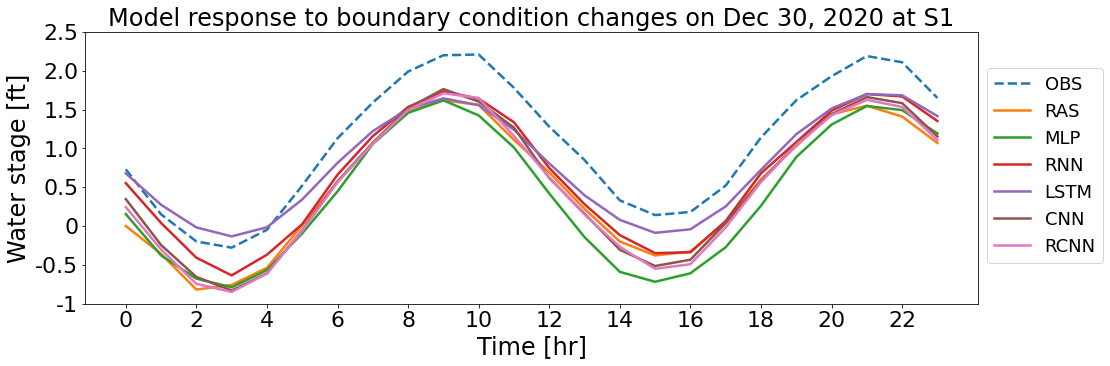

In [24]:
df = pd.DataFrame(columns = ['OBS', 'RAS', 'MLP', 'RNN', 'LSTM', 'CMLP', 'CRNN'])
df.iloc[:, 0] = refer.iloc[:, 0]
df.iloc[:, 1] = refer.iloc[:, 1]
df.iloc[:, 2] = inv_yhat_mlp_reshape[:, 0]
df.iloc[:, 3] = inv_yhat_rnn_reshape[:, 0]
df.iloc[:, 4] = inv_yhat_lstm_reshape[:, 0]
df.iloc[:, 5] = inv_yhat_cmlp_reshape[:, 0]
df.iloc[:, 6] = inv_yhat_crnn_reshape[:, 0]

plt.rcParams["figure.figsize"] = (16, 5)

LINEWIDTH = 2.5
plt.plot(df.iloc[:, 0].values, linestyle='--', linewidth=LINEWIDTH, label='OBS')
plt.plot(df.iloc[:, 1].values, linewidth=LINEWIDTH, label='RAS')
plt.plot(df.iloc[:, 2].values, linewidth=LINEWIDTH, label='MLP')
plt.plot(df.iloc[:, 3].values, linewidth=LINEWIDTH, label='RNN')
plt.plot(df.iloc[:, 4].values, linewidth=LINEWIDTH, label='LSTM')
plt.plot(df.iloc[:, 5].values, linewidth=LINEWIDTH, label='CNN')
plt.plot(df.iloc[:, 6].values, linewidth=LINEWIDTH, label='RCNN')

plt.tick_params(axis='both', which='both', bottom='on', left='on', labelbottom='on', labelleft='on')

plt.xlabel('Time [hr]', fontsize=24)
plt.ylabel('Water stage [ft]', fontsize=24)
plt.xticks(np.arange(0, 24, step=2), [i for i in range(0, 24, 2)], fontsize=22)
plt.yticks(np.arange(-1, 3, step=0.5), [-1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=22)
plt.title('Model response to boundary condition changes on Dec 30, 2020 at S1', fontsize=24)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.9))

# plt.savefig('../figures/11-1.png', dpi=400, bbox_inches='tight')

plt.show()

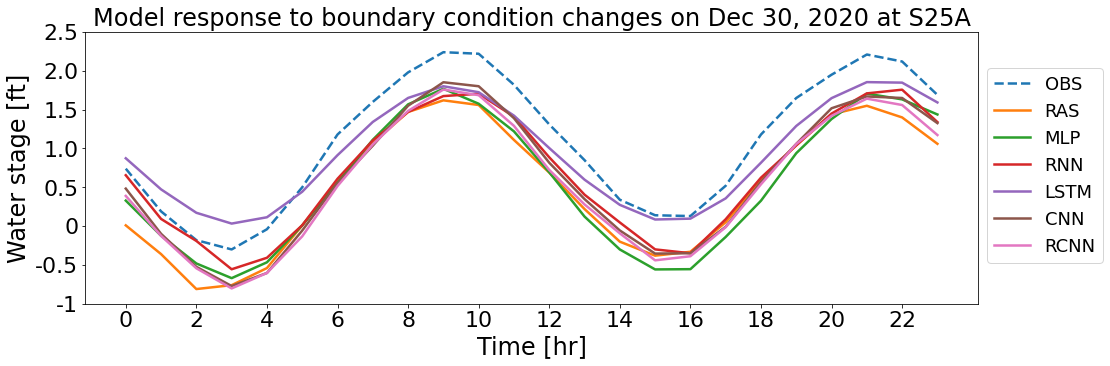

In [25]:
df1 = pd.DataFrame(columns = ['OBS', 'RAS', 'MLP', 'RNN', 'LSTM', 'CMLP', 'CRNN'])
df1.iloc[:, 0] = refer.iloc[:, 2]
df1.iloc[:, 1] = refer.iloc[:, 3]
df1.iloc[:, 2] = inv_yhat_mlp_reshape[:, 1]
df1.iloc[:, 3] = inv_yhat_rnn_reshape[:, 1]
df1.iloc[:, 4] = inv_yhat_lstm_reshape[:, 1]
df1.iloc[:, 5] = inv_yhat_cmlp_reshape[:, 1]
df1.iloc[:, 6] = inv_yhat_crnn_reshape[:, 1]


plt.rcParams["figure.figsize"] = (16, 5)

LINEWIDTH = 2.5
plt.plot(df1.iloc[:, 0].values, linestyle='--', linewidth=LINEWIDTH, label='OBS')
plt.plot(df1.iloc[:, 1].values, linewidth=LINEWIDTH, label='RAS')
plt.plot(df1.iloc[:, 2].values, linewidth=LINEWIDTH, label='MLP')
plt.plot(df1.iloc[:, 3].values, linewidth=LINEWIDTH, label='RNN')
plt.plot(df1.iloc[:, 4].values, linewidth=LINEWIDTH, label='LSTM')
plt.plot(df1.iloc[:, 5].values, linewidth=LINEWIDTH, label='CNN')
plt.plot(df1.iloc[:, 6].values, linewidth=LINEWIDTH, label='RCNN')

plt.tick_params(axis='both', which='both', bottom='on', left='on', labelbottom='on', labelleft='on')

plt.xlabel('Time [hr]', fontsize=24)
plt.ylabel('Water stage [ft]', fontsize=24)
plt.xticks(np.arange(0, 24, step=2), [i for i in range(0, 24, 2)], fontsize=22)
plt.yticks(np.arange(-1, 3, step=0.5), [-1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=22)
plt.title('Model response to boundary condition changes on Dec 30, 2020 at S25A', fontsize=24)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.9))

# plt.savefig('../figures/11-2.png', dpi=400, bbox_inches='tight')
plt.show()

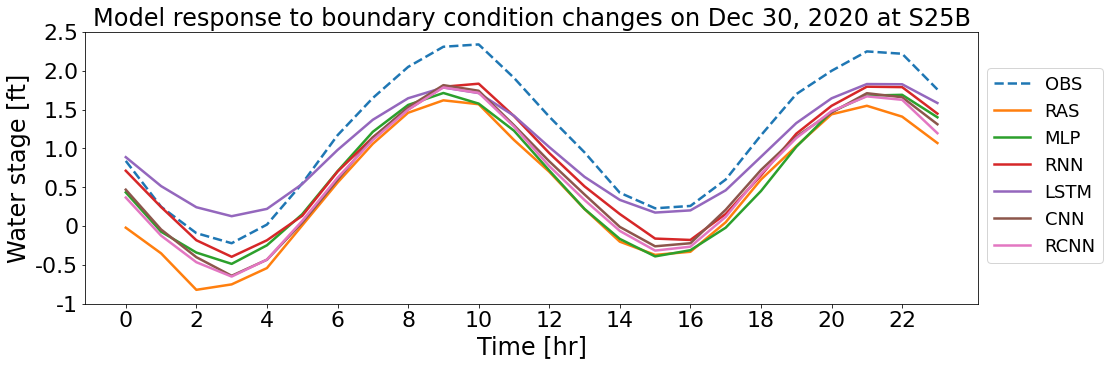

In [26]:
df2= pd.DataFrame(columns = ['OBS', 'RAS', 'MLP', 'RNN', 'LSTM', 'CMLP', 'CRNN'])
df2.iloc[:, 0] = refer.iloc[:, 4]
df2.iloc[:, 1] = refer.iloc[:, 5]
df2.iloc[:, 2] = inv_yhat_mlp_reshape[:, 2]
df2.iloc[:, 3] = inv_yhat_rnn_reshape[:, 2]
df2.iloc[:, 4] = inv_yhat_lstm_reshape[:, 2]
df2.iloc[:, 5] = inv_yhat_cmlp_reshape[:, 2]
df2.iloc[:, 6] = inv_yhat_crnn_reshape[:, 2]


plt.rcParams["figure.figsize"] = (16, 5)

LINEWIDTH = 2.5
plt.plot(df2.iloc[:, 0].values, linestyle='--', linewidth=LINEWIDTH, label='OBS')
plt.plot(df2.iloc[:, 1].values, linewidth=LINEWIDTH, label='RAS')
plt.plot(df2.iloc[:, 2].values, linewidth=LINEWIDTH, label='MLP')
plt.plot(df2.iloc[:, 3].values, linewidth=LINEWIDTH, label='RNN')
plt.plot(df2.iloc[:, 4].values, linewidth=LINEWIDTH, label='LSTM')
plt.plot(df2.iloc[:, 5].values, linewidth=LINEWIDTH, label='CNN')
plt.plot(df2.iloc[:, 6].values, linewidth=LINEWIDTH, label='RCNN')

plt.tick_params(axis='both', which='both', bottom='on', left='on', labelbottom='on', labelleft='on')

plt.xlabel('Time [hr]', fontsize=24)
plt.ylabel('Water stage [ft]', fontsize=24)
plt.xticks(np.arange(0, 24, step=2), [i for i in range(0, 24, 2)], fontsize=22)
plt.yticks(np.arange(-1, 3, step=0.5), [-1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=22)
plt.title('Model response to boundary condition changes on Dec 30, 2020 at S25B', fontsize=24)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.9))

# plt.savefig('../figures/11-3.png', dpi=400, bbox_inches='tight')
plt.show()

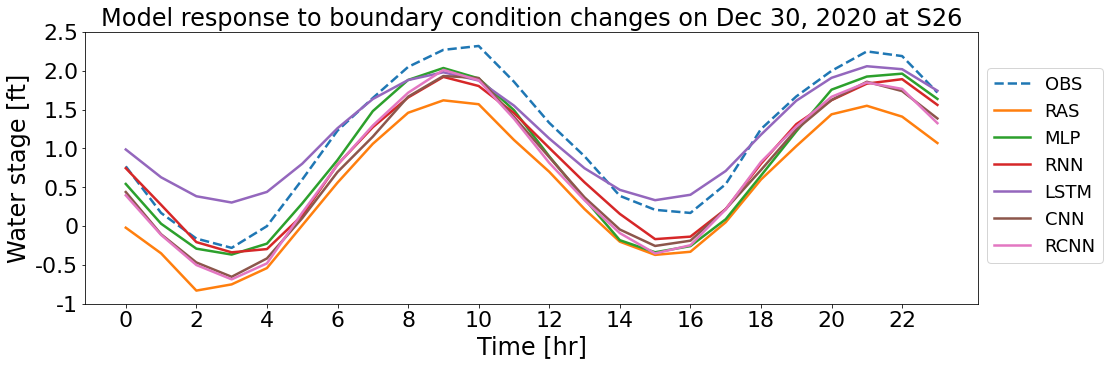

In [27]:
df3= pd.DataFrame(columns = ['OBS', 'RAS', 'MLP', 'RNN', 'LSTM', 'CMLP', 'RCNN'])
df3.iloc[:, 0] = refer.iloc[:, 6]
df3.iloc[:, 1] = refer.iloc[:, 7]
df3.iloc[:, 2] = inv_yhat_mlp_reshape[:, 3]
df3.iloc[:, 3] = inv_yhat_rnn_reshape[:, 3]
df3.iloc[:, 4] = inv_yhat_lstm_reshape[:, 3]
df3.iloc[:, 5] = inv_yhat_cmlp_reshape[:, 3]
df3.iloc[:, 6] = inv_yhat_crnn_reshape[:, 3]


plt.rcParams["figure.figsize"] = (16, 5)

LINEWIDTH = 2.5
plt.plot(df3.iloc[:, 0].values, linestyle='--', linewidth=LINEWIDTH, label='OBS')
plt.plot(df3.iloc[:, 1].values, linewidth=LINEWIDTH, label='RAS')
plt.plot(df3.iloc[:, 2].values, linewidth=LINEWIDTH, label='MLP')
plt.plot(df3.iloc[:, 3].values, linewidth=LINEWIDTH, label='RNN')
plt.plot(df3.iloc[:, 4].values, linewidth=LINEWIDTH, label='LSTM')
plt.plot(df3.iloc[:, 5].values, linewidth=LINEWIDTH, label='CNN')
plt.plot(df3.iloc[:, 6].values, linewidth=LINEWIDTH, label='RCNN')

plt.tick_params(axis='both', which='both', bottom='on', left='on', labelbottom='on', labelleft='on')

plt.xlabel('Time [hr]', fontsize=24)
plt.ylabel('Water stage [ft]', fontsize=24)
plt.xticks(np.arange(0, 24, step=2), [i for i in range(0, 24, 2)], fontsize=22)
plt.yticks(np.arange(-1, 3, step=0.5), [-1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=22)
plt.title('Model response to boundary condition changes on Dec 30, 2020 at S26', fontsize=24)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.9))

# plt.savefig('../figures/11-4.png', dpi=400, bbox_inches='tight')
plt.show()